При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

In [127]:
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [9]:
rus_data = pd.read_csv("./data/lenta-ru-news.csv", dtype={'title': str, 'test': str, 'topic': str, 'tags': str}).dropna()

In [10]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [11]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [12]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

## Чистка данных

In [13]:
def clean_data(df):
    rusdata_df = df[(df['topic']!='Библиотека')&(df['topic']!='Бывший СССР')&(df['topic']!='69-я параллель')].reset_index(drop=True).sample(10000, random_state = 42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [14]:
rusdata_df, rusdata = clean_data(rus_data)

In [15]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [17]:
STOPWORDS_DIR = "stopwords"

In [18]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [21]:
stopwordsru = get_stop_words()

In [27]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

### Токенизация

In [22]:
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha() and t.lower() not in stopwordsru)

In [25]:
data = [process(t) for t in rusdata]

## Лемматизация

In [30]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [31]:
morph_data = lemmatizer(data)

In [32]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [33]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

# Визуализация

In [38]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

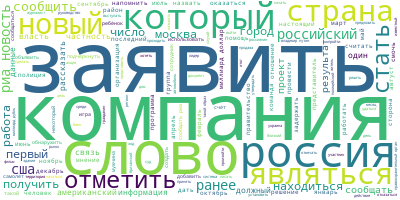

In [39]:
wordcloud_visualization(data_norm)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [40]:
bigram = gensim.models.Phrases(data_norm, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_norm], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [41]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data_norm)

In [42]:
print(data_words_trigrams[0])

['один', 'завод', 'город', 'салфита', 'западный_берег', 'израильский', 'военный', 'обнаружить', 'называть', 'пояс_шахид', 'предназначить', 'совершение_теракт', 'посредством', 'самоубийство', 'сообщать', 'издание', 'сведение', 'израильский', 'спецслужба', 'исламский', 'экстремист', 'подготовить', 'сто', 'планироваться', 'направить', 'иерусалим', 'данные', 'ряд', 'источник', 'финансировать', 'подобный', 'процесс', 'подготовка', 'теракт', 'структура', 'базироваться', 'саудовский_аравия', 'агентство', 'выяснить', 'накануне', 'саудовский_аравия', 'счёт', 'семья', 'самоубийца', 'джамаль', 'нассера', 'поступить', 'доллар', 'совершить', 'теракт', 'район', 'наблус', 'врезаться', 'автобус', 'машина', 'загрузить', 'взывчатка', 'подобный', 'платёж', 'семья', 'погибнуть', 'палестинский', 'террорист', 'регулярно', 'проходить', 'саудовский_аравия', 'утверждать', 'источник', 'среда', 'министр_внутренний', 'саудовский_аравия', 'найефа', 'бин', 'приказать', 'перечислить', 'доллар', 'счёт', 'некий', 'пал

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [43]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [44]:
dictionary[8]

'взывчатка'

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [54]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

# Построение модели LDA Topic Modelling

## Использование корпуса без TF-IDF фильтрации

In [63]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [64]:
pprint(lda_model.show_topics(formatted=False))

[(75,
  [('ахалкаци', 1.5541462e-05),
   ('тгк', 1.5541462e-05),
   ('vegas', 1.5541462e-05),
   ('avenue', 1.5541462e-05),
   ('ффг', 1.5541462e-05),
   ('жиресс', 1.5541462e-05),
   ('агаларов', 1.5541462e-05),
   ('энергокомпания', 1.5541462e-05),
   ('петролеум', 1.5541462e-05),
   ('русиа', 1.5541462e-05)]),
 (10,
  [('instagram', 0.115115),
   ('хранить', 0.0465041),
   ('жиресс', 1.30300705e-05),
   ('тгк', 1.30300705e-05),
   ('vegascrocuscity', 1.30300705e-05),
   ('vegas', 1.30300705e-05),
   ('avenue', 1.30300705e-05),
   ('ффг', 1.30300705e-05),
   ('арас', 1.30300705e-05),
   ('ахалкаци', 1.30300705e-05)]),
 (57,
  [('гражданский', 0.2093992),
   ('образовать', 0.047842108),
   ('ахалкаци', 1.1543915e-05),
   ('тгк', 1.1543915e-05),
   ('vegas', 1.1543915e-05),
   ('avenue', 1.1543915e-05),
   ('ффг', 1.1543915e-05),
   ('жиресс', 1.1543915e-05),
   ('агаларов', 1.1543915e-05),
   ('петролеум', 1.1543915e-05)]),
 (27,
  [('ошибка', 0.12202335),
   ('сигнал', 0.092483215),


In [65]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,71,18,0.2355,0.1445,"территория, военный, журналист, теракт, сведен...","слово, новый, сайт, который, правительство, вл...",На одном из заводов в городе Салфит на Западно...
1,15,18,0.1322,0.1282,"заявить, президент, представитель, глава, отме...","слово, новый, сайт, который, правительство, вл...",Госсекретарь США Колин Пауэлл вновь встретился...
2,53,18,0.244,0.1287,"компания, планировать, сеть, различный, предос...","слово, новый, сайт, который, правительство, вл...",МТС предложила сократить срок эмбарго на строи...
3,15,55,0.1131,0.1043,"заявить, президент, представитель, глава, отме...","сообщать, страна, первый, стать, получить, оди...",Экс-чемпион мира по боксу Константин Цзю посту...
4,66,18,0.2834,0.1327,"известный, создать, имя, телеканал, стать_изве...","слово, новый, сайт, который, правительство, вл...","Народный художник России, кинодекоратор Алекса..."
5,59,55,0.2792,0.1534,"победа, основать, турнир, владеть, тур, испани...","сообщать, страна, первый, стать, получить, оди...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,18,46,0.1277,0.1221,"слово, новый, сайт, который, правительство, вл...","фильм, картина, режиссёр, комплекс, лента, бое...",Бюджетный комитет федерального парламента Герм...
7,13,55,0.3217,0.1538,"производство, выпустить, завод, модель, принад...","сообщать, страна, первый, стать, получить, оди...",Продажи нового бюджетного седана Nissan Almera...
8,45,34,0.1895,0.1115,"обвинять, заседание, штраф, организовать, судь...","the, клиент, кризис, заключение, дэвид, альбом...","Двое американцев, занимавшихся мошенничеством ..."
9,18,15,0.1993,0.1388,"слово, новый, сайт, который, правительство, вл...","заявить, президент, представитель, глава, отме...",Более четверти бывших министров администрации ...


In [66]:
df_dominant_topic.loc[2]["text"]

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

In [67]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'компания, планировать, сеть, различный, предоставить, контракт, партнёр, услуга, сокращение, оператор'

In [68]:
df_dominant_topic.to_csv('./results/dominant_topic_no_tfidf_limit.csv', index= False)

## Визуализация

In [128]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_no_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.278340  0.256440       1        1  13.016962
15     0.266723  0.136461       2        1  10.817045
55     0.270067  0.170721       3        1  10.411794
5      0.247030  0.222423       4        1   5.093689
8      0.171193 -0.049120       5        1   2.868340
...         ...       ...     ...      ...        ...
29    -0.198423  0.039663      76        1   0.066615
27    -0.204149  0.039512      77        1   0.061504
57    -0.209753  0.039221      78        1   0.046292
10    -0.218721  0.038465      79        1   0.022097
75    -0.230586  0.037010      80        1   0.004009

[80 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
292       россия  7731.000000  7731.000000  Default   30.000  30.0000
175     компания  6116.000000  6116.000000  Default   29.000  29.0000
291   российский  5497.000000  5497.000000  Default   28.000  28.0000
94           сша  3988.000000  3988.000000  Default   27.000  27.0000
119      заявить  6581.000000  6581.000000  Default   26.000  26.0000
..           ...          ...          ...      ...      ...      ...
25     иерусалим     0.000661    95.617306  Topic80  -11.072  -1.7575
26       издание     0.000661  1911.610770  Topic80  -11.072  -4.7528
27   израильский     0.000661   386.979325  Topic80  -11.072  -3.1555
28         иметь     0.000661   713.245804  Topic80  -11.072  -3.7670
29    информация     0.000661  2728.076792  Topic80  -11.072  -5.1085

[2959 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3035     58  0.996793        afp
399      32  0.993558     agence
468      61  0.989788        and
614      61  0.473671        aol
1473     38  0.983471        bbc
...     ...       ...        ...
811       3  0.039912     январь
613      45  0.995337     япония
869      45  0.994769   японский
2061     34  0.956480  ярославль
4133     36  0.984258       ясно

[2190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 16, 56, 6, 9, 59, 22, 52, 29, 8, 67, 72, 32, 54, 13, 12, 31, 15, 46, 36, 69, 37, 74, 27, 39, 55, 71, 41, 64, 77, 7, 33, 17, 34, 62, 66, 1, 10, 65, 51, 79, 3, 47, 40, 21, 45, 26, 2, 73, 57, 24, 14, 60, 75, 23, 5, 18, 49, 68, 80, 35, 63, 4, 20, 43, 48, 25, 61, 42, 38, 53, 50, 70, 44, 78, 30, 28, 58, 11, 76])

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [70]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -39.16242401912648


# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_topics$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

## Дополнительное задание (2 балла)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [106]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary, normalize=False)

# let's count true percentiles
tfidf_range = [x[1] for x in sum(tfidf[corpus], [])]
tf_max = max(tfidf_range)
tf_min = min(tfidf_range)

print(tf_max, tf_min)

print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

196.6033980727912 1.213236378814949
19.252042979898135 3.532824877385981


In [146]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

invalid_ids = set(sum([[x[0] for x in tfidf[text] if (x[1] < low_value or x[1] > high_value)] for text in corpus], []))

filtered_corpus = []
data_filtered = []
for i in range(0, len(corpus)):
       
    filter_ids = [x[0] for x in corpus[i] if x[0] not in invalid_ids]
    
    new_bow = [x for x in corpus[i] if x[0] in filter_ids]
      
    if len(new_bow) > 0:
        filtered_corpus.append(new_bow)
        data_filtered.append(rusdata.iloc[i])
data_filtered = pd.Series(data_filtered)

In [147]:
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                                  id2word=dictionary,
                                                  num_topics=80, 
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha='auto',
                                                  per_word_topics=True)

In [148]:
# Show Topics
pprint(lda_model_tfidf.show_topics(formatted=False))

[(78,
  [('ахалкаци', 1.5541462e-05),
   ('тгк', 1.5541462e-05),
   ('vegas', 1.5541462e-05),
   ('avenue', 1.5541462e-05),
   ('ффг', 1.5541462e-05),
   ('жиресс', 1.5541462e-05),
   ('агаларов', 1.5541462e-05),
   ('энергокомпания', 1.5541462e-05),
   ('петролеум', 1.5541462e-05),
   ('русиа', 1.5541462e-05)]),
 (30,
  [('ахалкаци', 1.5541462e-05),
   ('тгк', 1.5541462e-05),
   ('vegas', 1.5541462e-05),
   ('avenue', 1.5541462e-05),
   ('ффг', 1.5541462e-05),
   ('жиресс', 1.5541462e-05),
   ('агаларов', 1.5541462e-05),
   ('энергокомпания', 1.5541462e-05),
   ('петролеум', 1.5541462e-05),
   ('русиа', 1.5541462e-05)]),
 (68,
  [('ахалкаци', 1.5541462e-05),
   ('тгк', 1.5541462e-05),
   ('vegas', 1.5541462e-05),
   ('avenue', 1.5541462e-05),
   ('ффг', 1.5541462e-05),
   ('жиресс', 1.5541462e-05),
   ('агаларов', 1.5541462e-05),
   ('энергокомпания', 1.5541462e-05),
   ('петролеум', 1.5541462e-05),
   ('русиа', 1.5541462e-05)]),
 (33,
  [('ахалкаци', 1.5541462e-05),
   ('тгк', 1.5541

In [151]:
warnings.simplefilter('ignore')

In [153]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf')

LDAvis_prepared = gensimvis.prepare(lda_model_tfidf, filtered_corpus, dictionary, mds='mmds')
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_with_tfidf' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
43     0.564473  0.031414       1        1  9.755845
59     0.239488  0.409787       2        1  3.114625
0      0.337532  0.290500       3        1  2.408897
56    -0.433145 -0.090062       4        1  2.211623
34     0.271287 -0.335923       5        1  2.166104
...         ...       ...     ...      ...       ...
74    -0.006754  0.003016      76        1  0.008048
10    -0.006754  0.003015      77        1  0.008048
48    -0.006754  0.003016      78        1  0.008048
67    -0.006754  0.003016      79        1  0.008048
33    -0.006754  0.003016      80        1  0.008048

[80 rows x 5 columns], topic_info=                Term         Freq        Total Category  logprob  loglift
275        напомнить  1382.000000  1382.000000  Default   30.000  30.0000
1205              рф  1483.000000  1483.000000  Default   29.000  29.0000
2405        действие  1509.000000  1509.000000  Default   28.000  28.0000
923           помощь  1321.000000  1321.000000  Default   27.000  27.0000
44         некоторый  1640.000000  1640.000000  Default   26.000  26.0000
...              ...          ...          ...      ...      ...      ...
12          выяснить     0.000421   219.790614  Topic80  -11.072  -3.7387
21         загрузить     0.000421    33.821053  Topic80  -11.072  -1.8671
23    западный_берег     0.000421    30.309734  Topic80  -11.072  -1.7575
24          заявлять     0.000421   418.544659  Topic80  -11.072  -4.3828
28             иметь     0.000421   787.891436  Topic80  -11.072  -5.0154

[2732 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
3819     27  0.932236         abc_news
3035      6  0.997152              afp
399       5  0.994751           agence
4135     50  0.937283              all
2107     66  0.927276          charles
...     ...       ...              ...
2218     19  0.946587  южноафриканский
4205     15  0.965318    южный_америка
3818     25  0.886249       юрисдикция
2592     65  0.935706      ярославский
4133     17  0.984168             ясно

[1193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[44, 60, 1, 57, 35, 50, 14, 65, 41, 36, 58, 59, 48, 6, 16, 62, 13, 56, 19, 72, 73, 55, 37, 66, 27, 45, 33, 18, 71, 7, 17, 43, 80, 5, 10, 28, 12, 78, 52, 9, 47, 25, 63, 3, 77, 15, 29, 70, 38, 64, 46, 40, 39, 32, 67, 61, 23, 22, 20, 53, 8, 24, 26, 54, 51, 74, 21, 30, 2, 76, 4, 79, 42, 31, 69, 75, 11, 49, 68, 34])

In [154]:
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(filtered_corpus))  


Perplexity:  -46.74200766717814


In [155]:
print(f'Previous perplexity (without tfidf): {lda_model.log_perplexity(corpus)}')

Previous perplexity (without tfidf): -39.162424209975356


Perplexity стала меньше, как и хотелось.

In [157]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=filtered_corpus, texts=data_filtered.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,71,43,0.1843,0.0983,"утверждать, подобный, называть, призвать, неки...","сторона, писать, причина, назвать, согласно, п...",На одном из заводов в городе Салфит на Западно...
1,6,43,0.1678,0.073,"больший, ожидаться, скорее, запланировать, гот...","сторона, писать, причина, назвать, согласно, п...",Госсекретарь США Колин Пауэлл вновь встретился...
2,43,23,0.1004,0.099,"сторона, писать, причина, назвать, согласно, п...","завершиться, рассмотреть, оказывать, доставить...",МТС предложила сократить срок эмбарго на строи...
3,70,43,0.1302,0.0872,"начаться, прошлый, вместо, четвёртый, постоянн...","сторона, писать, причина, назвать, согласно, п...",Экс-чемпион мира по боксу Константин Цзю посту...
4,5,43,0.096,0.0772,"ссылка, необходимо, превысить, присутствовать,...","сторона, писать, причина, назвать, согласно, п...","Народный художник России, кинодекоратор Алекса..."
5,47,43,0.1392,0.0828,"специальный, позволить, предполагаться, сущест...","сторона, писать, причина, назвать, согласно, п...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,46,43,0.1659,0.0792,"условие, высокий, использоваться, министерство...","сторона, писать, причина, назвать, согласно, п...",Бюджетный комитет федерального парламента Герм...
7,43,7,0.073,0.0716,"сторона, писать, причина, назвать, согласно, п...","планироваться, указать, принадлежащий, предпол...",Продажи нового бюджетного седана Nissan Almera...
8,39,34,0.1047,0.1013,"нападать, лето, предварительный, поездка, девя...","часть, reuters, связанный, снизить, минимум, a...","Двое американцев, занимавшихся мошенничеством ..."
9,54,43,0.1945,0.0881,"деятельность, вести, возглавлять, официально, ...","сторона, писать, причина, назвать, согласно, п...",Более четверти бывших министров администрации ...


In [158]:
df_dominant_topic.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [161]:
df_dominant_topic.loc[6]["text"]

'Бюджетный комитет федерального парламента Германии одобрил 13 мая 2009 года сделку по приобретению военным ведомством страны двух тактических систем перехвата C-RAM (Counter Rockets, Artillery and Mortar) стоимостью 136 миллионов евро, сообщает DefPro. Об этом сообщили в министерстве обороны Германии. C-RAM является наземной модификацией корабельного комплекса Phalanx разработки General Dynamics, которые используются на боевых кораблях ВМС и береговой охраны США. C-RAM была разработана в интересах международного контингента в Ираке для отражения атак ракет, артиллерийских снарядов и боеприпасов минометов. Система способна засечь и нейтрализовать эти цели еще до того, как они достигнут земли. Новые комплексы были приняты на вооружение в 2005 году, а в 2006 году был осуществлен первый перехват цели в боевых условиях. Американцы отметили высокую эффективность этого вооружения в условиях контртеррористических операций в Ираке и Афганистане. Германские военные также планируют использовать 

In [162]:
df_dominant_topic.loc[6]["Topic_Keywords1"]

'условие, высокий, использоваться, министерство_оборона, боевой, перспектива, приобретение, эффективность, нейтрализовать, vegas'

Так же, как и без tfidf фильтрации, есть документы, у которых подобранная тема хорошо их описывает, как, например, в случае выше. При этом процент этой темы не высок.

In [165]:
df_dominant_topic['%Topic_Contribution1'].max()

0.2862

Самые подходящие темы не набирают высокий скор, возможно, потому что многие из них по смыслу перекрывают друг друга. Для лучшего отделения тем надо больше данных.

## Посты о политике с Пикабу

In [168]:
pikabu_data = pd.read_csv("./data/pikabu_posts.csv").dropna()
pikabudata = pikabu_data['content']

In [170]:
pdata = [process(t) for t in pikabudata]

morph_pdata = lemmatizer(pdata)
pdata_norm = extract_lemma(morph_pdata)

pbigram = gensim.models.Phrases(pdata_norm, min_count=5, threshold=100) 
ptrigram = gensim.models.Phrases(pbigram[pdata_norm], threshold=100)  

pbigram_mod = gensim.models.phrases.Phraser(pbigram)
ptrigram_mod = gensim.models.phrases.Phraser(ptrigram)

pdata_words_trigrams = make_trigrams(pdata_norm)

pdictionary = corpora.Dictionary(pdata_words_trigrams)

pcorpus = [pdictionary.doc2bow(doc) for doc in pdata_words_trigrams]

In [207]:
ptfidf = gensim.models.TfidfModel(pcorpus, id2word = pdictionary, normalize=False)

# let's count true percentiles
ptfidf_range = [x[1] for x in sum(ptfidf[pcorpus], [])]
ptf_max = max(ptfidf_range)
ptf_min = min(ptfidf_range)

plow_value = np.percentile(ptfidf_range, 10) 
phigh_value = np.percentile(ptfidf_range, 95) 

pinvalid_ids = set(sum([[x[0] for x in ptfidf[text] if (x[1] < plow_value or x[1] > phigh_value)] for text in pcorpus], []))

pfiltered_corpus = []
pdata_filtered = []
for i in range(0, len(pcorpus)):
       
    pfilter_ids = [x[0] for x in pcorpus[i] if x[0] not in pinvalid_ids]
    
    pnew_bow = [x for x in pcorpus[i] if x[0] in pfilter_ids]
      
    if len(pnew_bow) > 0:
        pfiltered_corpus.append(pnew_bow)
        pdata_filtered.append(pikabudata.iloc[i])
pdata_filtered = pd.Series(pdata_filtered)

In [172]:
plda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=pfiltered_corpus,
                                                   id2word=pdictionary,
                                                   num_topics=80, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)

In [174]:
pyLDAvis.enable_notebook()
pLDAvis_data_filepath = os.path.join('./results/ldavis_prepared_pikabu_with_tfidf')

pLDAvis_prepared = gensimvis.prepare(plda_model_tfidf, pfiltered_corpus, pdictionary, mds='mmds')
with open(pLDAvis_data_filepath, 'wb') as f:
    pickle.dump(pLDAvis_prepared, f)

with open(pLDAvis_data_filepath, 'rb') as f:
    pLDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(pLDAvis_prepared, './results/ldavis_pikabu_with_tfidf' +'.html')
pLDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.498916  0.037116       1        1  15.321224
66     0.200350  0.433272       2        1  11.449791
16     0.360226  0.271706       3        1   9.511301
56    -0.450407 -0.095362       4        1   8.242917
72     0.272355 -0.299080       5        1   5.854020
...         ...       ...     ...      ...        ...
3     -0.010468  0.005417      76        1   0.013623
17    -0.010470  0.005417      77        1   0.013623
70    -0.010468  0.005417      78        1   0.013524
26    -0.010469  0.005418      79        1   0.013524
68    -0.010467  0.005419      80        1   0.013424

[80 rows x 5 columns], topic_info=                      Term       Freq       Total Category  logprob  loglift
95                 принять  208.00000  208.000000  Default  30.0000  30.0000
424                  смочь  168.00000  168.000000  Default  29.0000  29.0000
1059                  мера  133.00000  133.000000  Default  28.0000  28.0000
3228                пример  126.00000  126.000000  Default  27.0000  27.0000
2206               просьба  119.00000  119.000000  Default  26.0000  26.0000
...                    ...        ...         ...      ...      ...      ...
22          вышеупомянутый    0.00034    2.597936  Topic80  -9.5822  -0.0241
23                 гласить    0.00034    5.354670  Topic80  -9.5822  -0.7473
26    государственный_дума    0.00034    3.084388  Topic80  -9.5822  -0.1957
27                  данные    0.00034   82.746467  Topic80  -9.5822  -3.4851
29               детальный    0.00034    2.597579  Topic80  -9.5822  -0.0239

[3541 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9        12  0.561550  connect
3029     28  0.546438   forbes
2526     24  0.740453   george
2527     32  0.670259      had
2529     32  0.645484      his
...     ...       ...      ...
484       7  0.654269  эксперт
2870     40  0.811434     эфир
3741     45  0.718581    ютуба
1952     26  0.666503   яндекс
4343     11  0.902090    яркий

[1732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 67, 17, 57, 73, 77, 3, 25, 40, 22, 38, 60, 78, 74, 9, 31, 50, 39, 34, 75, 30, 79, 2, 43, 7, 44, 58, 21, 49, 47, 15, 61, 72, 16, 80, 46, 68, 11, 45, 13, 33, 63, 24, 48, 29, 23, 8, 70, 66, 55, 59, 54, 41, 37, 32, 42, 28, 51, 52, 35, 19, 64, 36, 20, 26, 5, 62, 1, 12, 76, 14, 53, 65, 56, 6, 4, 18, 71, 27, 69])

In [175]:
print('\nPerplexity: ', plda_model_tfidf.log_perplexity(pfiltered_corpus))  


Perplexity:  -45.06159000885386


In [209]:
pdf_topic_sents_keywords = format_topics_sentences(ldamodel=plda_model_tfidf, corpus=pfiltered_corpus, texts=pdata_filtered.values)


pdf_dominant_topic = pdf_topic_sents_keywords.reset_index(drop = True)
pdf_dominant_topic.to_csv('./results/dominant_topic_pikabu_with_tfidf_limit.csv', index= False)
pdf_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,9,56,0.3212,0.17,"коллега, отвечать, данный, соответствовать, пр...","всякий, поступить, молчать, компания, друг, ар...","Не помогло, всё равно задержали\nПикабу●0:18\n..."
1,59,9,0.69,0.1182,"автор, аналогичный, другой, привязать, следующ...","коллега, отвечать, данный, соответствовать, пр...",Вышеупомянутая инициатива была опубликована на...
2,76,2,0.4566,0.3823,"смочь, защитить, обратиться, управлять, мир, р...","принять, млрд, обращение, владимир_путин, попр...",Мост через реку Пур с госучастием строят по сф...
3,9,77,0.1433,0.1046,"коллега, отвечать, данный, соответствовать, пр...","сильный, желать, различный, инвалид, подарить,...","Работники ""ГродноАзот"" обьявили забастовку в с..."
4,66,9,0.5437,0.12,"сила, возможный, применение, доступ, иметь, на...","коллега, отвечать, данный, соответствовать, пр...",С 2003 года я не смотрел и не слушал выступлен...
5,22,66,0.3229,0.1917,"вовсе, хулиган, задать, соперник, стекло, повт...","сила, возможный, применение, доступ, иметь, на...","Работник ""Гродножилстрой"" на встрече с директо..."
6,30,66,0.4457,0.1107,"тема, обязать, внимание, социальный, дорогой, ...","сила, возможный, применение, доступ, иметь, на...",На волнах Орды рубрика «Среди твоих детей мало...
7,16,56,0.8609,0.0179,"отрезать, постоянно, ждать, никакой, комментар...","всякий, поступить, молчать, компания, друг, ар...",В больницу из Партизанского РУВД Минска привез...
8,72,9,0.1342,0.1256,"стоить, настоящий, молодой, возможность, выход...","коллега, отвечать, данный, соответствовать, пр...",Наверное дедушка злостный террорист. Почему та...
9,39,37,0.2169,0.1197,"пример, мера, via, октябрь, подозревать, высту...","конкретный, удовлетворить, движение, главный, ...",В Берлине - прошла массовая демонстрация проти...


In [219]:
pdf_dominant_topic.loc[1]["text"]

'Вышеупомянутая инициатива была опубликована на РОИ (Российская общественная инициатива) 18 августа этого года. С момента публикации она набрала ровно 1000 голосов.\nЭто не может не радовать, поскольку инициатива может решить ряд проблем в сфере договоров касающихся современных услуг, вроде Сервисов Каршеринга, договоров об обработке персональных данных и договоров о цифровых услугах разного рода.\nКлючевой проблемой по мнению авторов инициативы является возможность, что договор будет изменен исполнителем услуг в одностороннем порядке, во многих договорах этот пункт прописан прямым текстом. Сервис, предоставляющий те или иные услуги может изменить ответственность сторон с явным перевесом преференций в свою сторону, или увеличить штрафные санкции за нарушение правил сервиса в разы без дополнительного уведомления.\n\nПользователь может оказаться в ситуации, когда он заключил договор с Каршеринговой Компанией и принял на себя ответственность в рамках одних цифр, скажем до 10.000 рублей, а

In [220]:
pdf_dominant_topic.loc[1]["Topic_Keywords1"]

'автор, аналогичный, другой, привязать, следующий, пройти, версия, тот, рамка, уровень'

Perplexity у модели на постах пикабу того же порядка, что и у предыдущих моделей. Темы предсказываются хорошо через раз, видно, что некоторые описывают конкретный комментарий:

In [221]:
pdf_dominant_topic.loc[16]["text"]

'Госсекретарь США Майк Помпео призвал к проведению новых президентских выборов в Белоруссии в присутствии международных наблюдателей. Об этом американский политик заявил по итогам переговоров с премьер-министром Словении Янезом Яншей.\n«Я считаю возможным лишь мирное решение текущего кризиса в Белоруссии, необходимо провести новые выборы при серьезном присутствии международных наблюдателей», — сказал Помпео.\nссылка'

In [222]:
pdf_dominant_topic.loc[16]["Topic_Keywords1"]

'политик, необходимо, переговоры, присутствие, международный, майк, помпео, яншея, словения, янез'